In [1]:
!pip install keras

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, LSTM, Reshape
from keras import regularizers
from os import listdir
from os.path import isfile, join
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(256,256, 1), n_channels=1,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.reshape(np.load(ID), (256, 256, 1, 1))

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [5]:
def add_Genre(partition, labels, genre, label):
    path = 'mel-spectrograms/' + genre
    files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    partition['train'].extend(files[1500:len(files)])
    partition['validation'].extend(files[0:1500])
    
    for file in files:
        labels[file] = label
        
    return partition, labels

partition = {'train':[], 'validation':[]}
labels = {}

partition, labels = add_Genre(partition, labels, 'Folk', 0)
partition, labels = add_Genre(partition, labels, 'Hip-Hop', 1)
partition, labels = add_Genre(partition, labels, 'Instrumental', 2)
partition, labels = add_Genre(partition, labels, 'Pop', 3)
partition, labels = add_Genre(partition, labels, 'Experimental', 4)

print('Training Size:', len(partition['train']))
print('Validation Size: ', len(partition['validation']))

Training Size: 17425
Validation Size:  7500


In [6]:
model = Sequential()
model.add(Reshape((256, 256, 1), input_shape=(256, 256, 1, 1)))
model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [7]:
# Parameters
params = {'dim': (256,256,1),
          'batch_size': 64,
          'n_classes': 5,
          'n_channels': 1,
          'shuffle': True}

epochs = 50

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Train model on dataset
history = model.fit_generator(generator=training_generator, 
                              validation_data=validation_generator, 
                              use_multiprocessing=True, 
                              workers=6,
                              epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
272/272 [==============================] - 61s 224ms/step - loss: 2.0792 - acc: 0.3918 - val_loss: 1.5935 - val_acc: 0.4963
Epoch 2/50
272/272 [==============================] - 52s 190ms/step - loss: 1.5119 - acc: 0.5029 - val_loss: 1.3339 - val_acc: 0.5581
Epoch 3/50
Epoch 2/50
272/272 [==============================] - 52s 191ms/step - loss: 1.3198 - acc: 0.5523 - val_loss: 1.2494 - val_acc: 0.5728
Epoch 4/50
272/272 [==============================] - 52s 191ms/step - loss: 1.2195 - acc: 0.5794 - val_loss: 1.1548 - val_acc: 0.5913
Epoch 5/50

272/272 [==============================] - 52s 190ms/step - loss: 1.1662 - acc: 0.5913 - val_loss: 1.1420 - val_acc: 0.5904
Epoch 6/50
272/272 [==============================] - 52s 192ms/step - loss: 1.1336 - acc: 0.6036 - val_loss: 1.1008 - val_acc: 0.6090
Epoch 7/50
272/272 [==============================] - 52s 192ms/step - loss: 1.1008 - acc: 0.6147 - val_loss: 1.1140 - val_acc: 0.

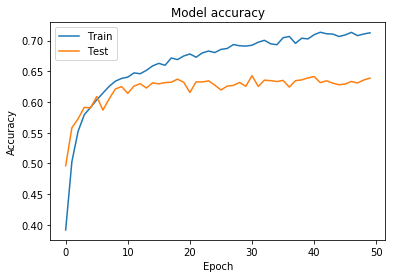

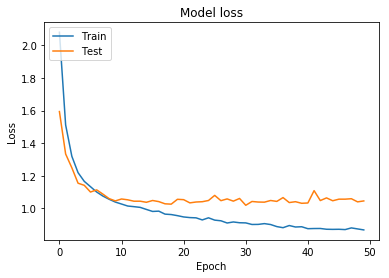

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()